In [1]:
#!pip3 install -U pandas matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sn
import scprep
import glob
import cv2
import os

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
from PIL import Image

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print ("Device is:", device)

Device is: cuda


In [4]:
#scprep.io.download.download_and_extract_zip(
#    url="https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip",
#    destination=".")

In [5]:
%ls -la ./InfraredSolarModules/

total 3072
drwxr-xr-x      5 mabreu  staff      160 Nov 16 15:36 ./
drwxr-xr-x     54 mabreu  staff     1728 Nov 19 17:45 ../
-rw-r--r--      1 mabreu  staff     8196 Nov 17 20:10 .DS_Store
drwxr-xr-x  20002 mabreu  staff   640064 Nov 16 15:36 images/
-rw-r--r--      1 mabreu  staff  1559444 Nov 16 15:36 module_metadata.json


In [4]:
dataset_path = "./InfraredSolarModules/"
dataset_path

'./InfraredSolarModules/'

In [5]:
imgs = glob.glob(dataset_path + "images/*.jpg")
len(imgs)

20000

In [6]:
full_df = pd.read_json(dataset_path + "module_metadata.json", orient='index').sort_index()
full_df['image_filepath'] = full_df.image_filepath.apply(lambda x: os.path.join(dataset_path, x))
len(full_df)

20000

In [7]:
# Optionally filter the DF
##df = full_df[full_df['anomaly_class'].isin(['Diode', 'Soiling', 'Hot-Spot'])]
#df = full_df[full_df['anomaly_class'].isin(['Cell',
# 'Vegetation',
# 'Diode',
# 'Cell-Multi',
# 'Shadowing',
# 'Cracking',
# 'Offline-Module',
# 'Hot-Spot',
# 'Hot-Spot-Multi',
# 'Soiling',
# 'Diode-Multi'])]
df = full_df.copy()
len(df)

20000

In [8]:
df.anomaly_class.value_counts().sort_values(ascending=True)

Diode-Multi         175
Soiling             204
Hot-Spot-Multi      246
Hot-Spot            249
Offline-Module      827
Cracking            940
Shadowing          1056
Cell-Multi         1288
Diode              1499
Vegetation         1639
Cell               1877
No-Anomaly        10000
Name: anomaly_class, dtype: int64

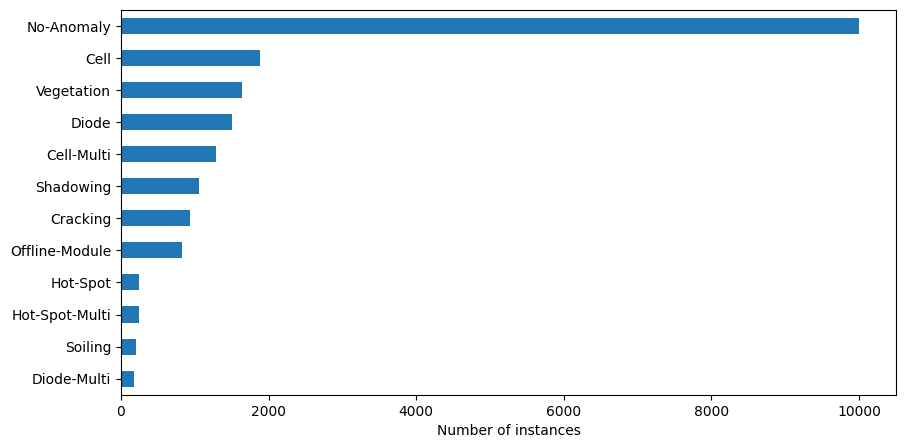

In [9]:
ax = df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.set_xlabel('Number of instances')
plt.show()

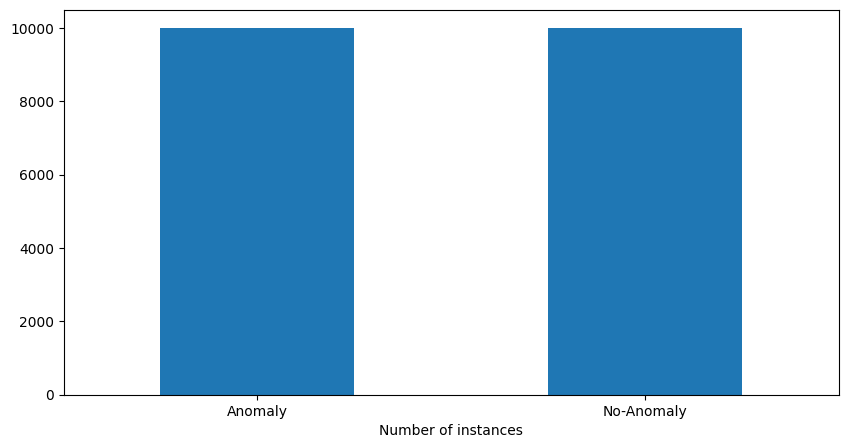

In [10]:
def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x

df_binary = df.copy()
df_binary['anomaly_class'] = df.anomaly_class.apply(convert_to_binary)
ax = df_binary['anomaly_class'].value_counts().plot.bar(figsize=(10,5))
ax.tick_params(labelrotation=0)
ax.set_xlabel('Number of instances')
plt.show()

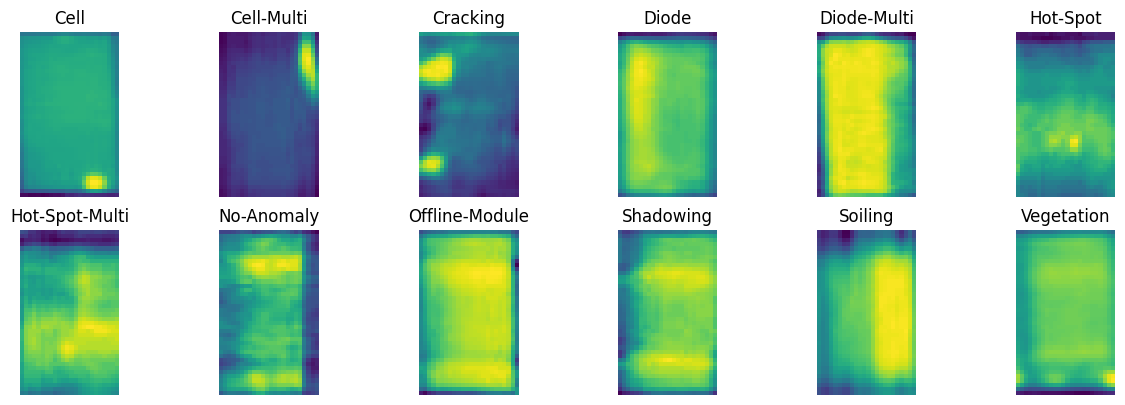

In [11]:
sample = df.groupby('anomaly_class').sample()

plt.figure(figsize=(15,15))
for i, (image_path, class_name) in enumerate(sample.values, start=1):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plt.subplot(6, 6, i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [12]:
transforms_list = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Grayscale(),
    #transforms.Normalize(mean=(0.5), std=(0.5)),
    #transforms.Normalize(mean=(0.0), std=(1.0)),
])
classes_list = df.anomaly_class.value_counts().keys().tolist()
num_classes = len(classes_list)

In [13]:
def process_img(path):
    #image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = Image.open(path).convert('RGB')
    image = transforms_list(image).numpy()
    image = (image * 2.0) - 1.0
    return image

In [14]:
def create_XY(df):
    imgs = []
    labels = []
    in_df = df.copy()
    for i, (p, c) in enumerate(in_df.values):
        image = process_img(p)
        labels.append(classes_list.index(c))
        imgs.append(image)
    return torch.tensor(np.array(imgs, dtype=np.float32)), torch.tensor(np.array(labels, dtype=np.float32))

In [16]:
rdm_state = 42

train_df = df.groupby('anomaly_class').sample(frac=0.80, random_state=rdm_state)
test_df = df.groupby('anomaly_class').sample(frac=0.20, random_state=rdm_state)
val_df = train_df.groupby('anomaly_class').sample(frac=0.20, random_state=rdm_state)
train_df = train_df.groupby('anomaly_class').sample(frac=0.80, random_state=rdm_state)
train_df_gan = train_df.copy()

max_per_class = int(train_df_gan.anomaly_class.value_counts().max())
train_df_gan = train_df_gan.groupby('anomaly_class').sample(max_per_class, replace=True, random_state=rdm_state) # Make it balanced for training

#train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)
#train_df, val_df = train_test_split(train_df, test_size=0.10, random_state=42)

X_train, y_train = create_XY(train_df)
X_train_g, y_train_g = create_XY(train_df_gan)
X_test, y_test = create_XY(test_df)
X_val, y_val = create_XY(val_df)

X_train.shape, X_test.shape, X_val.shape, X_train_g.shape 

(torch.Size([12801, 1, 40, 24]),
 torch.Size([4000, 1, 40, 24]),
 torch.Size([3199, 1, 40, 24]))

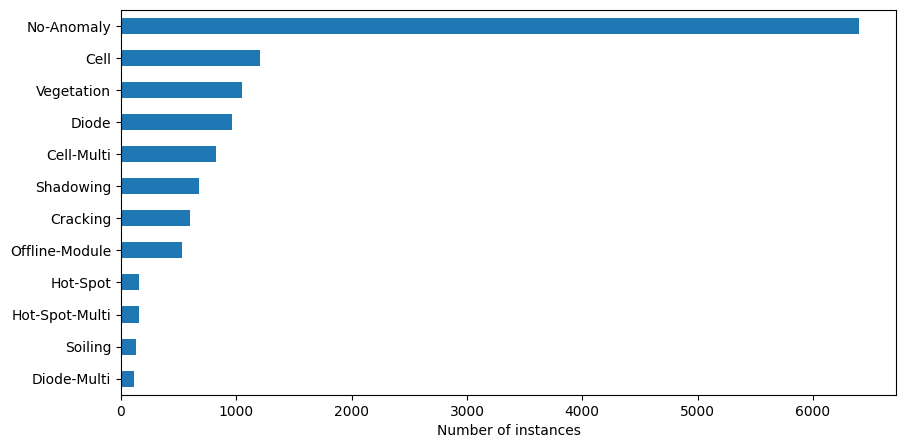

In [17]:
ax = train_df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.set_xlabel('Number of instances')
plt.show()

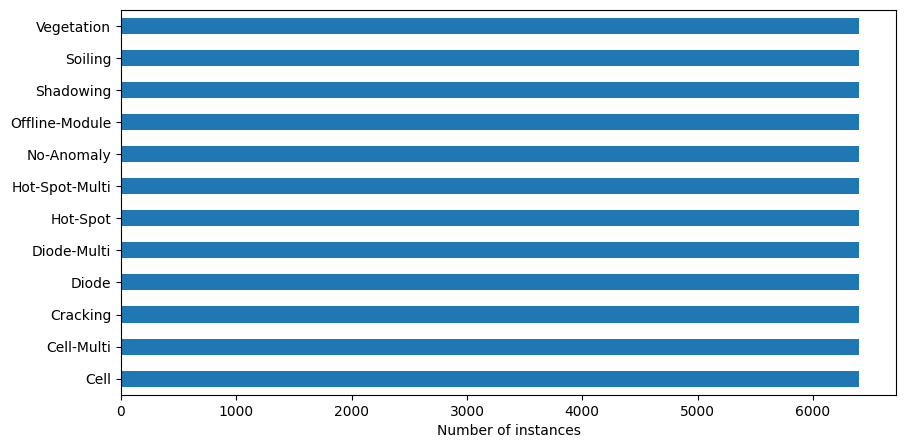

In [18]:
ax = train_df_gan.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.set_xlabel('Number of instances')
plt.show()

In [19]:
ax = test_df.anomaly_class.value_counts().sort_values(ascending=True)
ax

Diode-Multi         35
Soiling             41
Hot-Spot-Multi      49
Hot-Spot            50
Offline-Module     165
Cracking           188
Shadowing          211
Cell-Multi         258
Diode              300
Vegetation         328
Cell               375
No-Anomaly        2000
Name: anomaly_class, dtype: int64

In [20]:
ax = val_df.anomaly_class.value_counts().sort_values(ascending=True)
ax

Diode-Multi         28
Soiling             33
Hot-Spot-Multi      39
Hot-Spot            40
Offline-Module     132
Cracking           150
Shadowing          169
Cell-Multi         206
Diode              240
Vegetation         262
Cell               300
No-Anomaly        1600
Name: anomaly_class, dtype: int64

In [21]:
torch.min(X_train_g), torch.max(X_train_g)

(tensor(-1.), tensor(0.9998))

In [22]:
class Classificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            # BLock 1
            nn.Conv2d(in_dim[0], 80, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(80),
            # Block 2
            nn.Conv2d(80, 160, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(160),
            # Block 3
            nn.Conv2d(160, 320, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(320),
            # Block 4
            nn.Conv2d(320, 640, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(1, 2),
            nn.BatchNorm2d(640),
            # AVG POOL
            nn.AvgPool2d(2),
            # Fully connected
            nn.Flatten(),
            nn.Linear(640, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)

    def fit(self, X, y_target, optimizer, loss_fn=nn.CrossEntropyLoss(), epochs=10, batch_size=32, validation_data=None):
        dataset = TensorDataset(X, y_target)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for i, (x, y) in enumerate(dataloader):
                #x = x.to(device)
                #y = y.to(device)

                optimizer.zero_grad()
                y_hat = self.forward(x)
                one_hot = nn.functional.one_hot(y.to(torch.int64), num_classes=num_classes)
                labels = one_hot.to(torch.float32)
                loss = loss_fn(y_hat, labels)
                loss.backward()
                optimizer.step()

            if validation_data:
                (x_val, y_val) = validation_data
                #x_val = x_val.to(device)
                #y_val = y_val.to(device)
                with torch.no_grad():
                    y_hat = self.forward(x_val)
                    _, pred = torch.max(torch.softmax(y_hat, dim=1), dim=1)
                    val_acc = torch.sum(pred == y_val).item() / y_val.shape[0]
                print(f"[Epoch {epoch}/{epochs}] loss: {loss.item()}, val_acc: {val_acc}")
            else:
                print(f"[Epoch {epoch}/{epochs}] loss: {loss.item()}")

### check the CNN from the paper withou data augmentation

In [24]:
model = Classificator(in_dim=X_train.shape[1:], out_dim=num_classes).to(device)
print(summary(model, (1, X_train.shape[1], X_train.shape[2], X_train.shape[3])))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model.fit(
    X_train.to(device),
    y_train.to(device),
    optimizer,
    epochs=20,
    batch_size=64,
    validation_data=(X_val.to(device), y_val.to(device)),
)

Layer (type:depth-idx)                   Output Shape              Param #
Classificator                            [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 80, 40, 24]           800
│    └─ReLU: 2-2                         [1, 80, 40, 24]           --
│    └─MaxPool2d: 2-3                    [1, 80, 20, 12]           --
│    └─BatchNorm2d: 2-4                  [1, 80, 20, 12]           160
│    └─Conv2d: 2-5                       [1, 160, 20, 12]          115,360
│    └─ReLU: 2-6                         [1, 160, 20, 12]          --
│    └─MaxPool2d: 2-7                    [1, 160, 10, 6]           --
│    └─BatchNorm2d: 2-8                  [1, 160, 10, 6]           320
│    └─Conv2d: 2-9                       [1, 320, 10, 6]           461,120
│    └─ReLU: 2-10                        [1, 320, 10, 6]           --
│    └─MaxPool2d: 2-11                   [1, 320, 5, 3]            --
│ 

In [41]:
class GAugmented(nn.Module):
    def __init__(self, img_shape, latent_dim=100, features_gen=64, features_disc=64):
        super().__init__()
        self.img_size = img_shape[0] * img_shape[1] * img_shape[2]
        self.features_gen = features_gen
        self.features_disc = features_disc
        self.generator = self.Generator(latent_dim, img_shape, img_shape[0], features_gen, num_classes)
        self.generator.weight_init(mean=0.0, std=0.02)
        self.generator.to(device)
        self.discriminator = self.Discriminator(img_shape[0], features_disc, num_classes)
        self.discriminator.weight_init(mean=0.0, std=0.02)
        self.discriminator.to(device)
        self.lr = 0.0002
        self.batch_size = 128
        self.epochs = 20
        self.latent_dim = latent_dim
        self.img_shape = img_shape

        print(summary(self.generator,
                [(1, latent_dim, 1, 1), (1, num_classes, 1, 1)]))
        print(summary(self.discriminator,
                [(1, img_shape[0], img_shape[1], img_shape[2]),
                 (1, num_classes, img_shape[1], img_shape[2])]))

        # Optimizers and loss function
        beta1 = 0.5
        self.optimizer_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(beta1, 0.999))
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(beta1, 0.999))
        self.adversarial_loss = nn.BCELoss()

    def fit(self, dataloader):
        for epoch in range(self.epochs):
            for i, (real_imgs, real_labels) in enumerate(dataloader):
                self.train()
                batch_size = real_imgs.size(0)

                # Adversarial ground truths
                valid = torch.ones(batch_size, 1).to(device)
                fake = torch.zeros(batch_size, 1).to(device)
                #valid = torch.full((batch_size, 1), 0.95).to(device)
                #fake = torch.full((batch_size, 1), 0.05).to(device)

                one_hot = nn.functional.one_hot(real_labels.to(torch.int64), num_classes=num_classes)
                #l = torch.tensor(one_hot.clone().detach(), dtype=torch.float32)
                
                # W
                l = one_hot.to(torch.float32)
                l_g = l.view(batch_size, num_classes, 1, 1)
                l_d = l.view(batch_size, num_classes)
                l_d = l_d.repeat(real_imgs.size(2), real_imgs.size(3))
                l_d = l_d.view(batch_size, num_classes, real_imgs.size(2), real_imgs.size(3))

                #l_g = l.view(batch_size, num_classes, 1, 1).detach()
                #l_g = (torch.rand(batch_size, 1) * num_classes).type(torch.LongTensor).squeeze()
                #l_g = 
                #l_d = l.view(batch_size, num_classes).detach()
                #l_d = l_d.repeat(real_imgs.size(2), real_imgs.size(3))
                #l_d = l_d.view(batch_size, num_classes, real_imgs.size(2), real_imgs.size(3))
                #fill = l_d
                #f = fill[l_d]
                #l = l.view(real_imgs.size(0)

                #fill_d = torch.zeros([num_classes, num_classes, real_imgs.size(2), real_imgs.size(3)]).to(device)
                #fill_g = torch.zeros([num_classes, num_classes, 1, 1]).to(device)
                #for i in range(num_classes):
                #    fill_d[i, i, :, :] = 1
                #    fill_g[i, i, :, :] = 1

                z = torch.randn(batch_size, self.latent_dim, 1, 1).to(device)
                #z = torch.tensor(np.random.normal(0, 1, (batch_size, self.latent_dim, 1, 1)), dtype=torch.float32).to(device)
                ##zy = (torch.rand(batch_size, 1) * num_classes).type(torch.LongTensor).squeeze()
                
                #zone_hot = nn.functional.one_hot(zy.to(torch.int64), num_classes=num_classes)
                #lz = zone_hot.to(torch.float32)
                #l_g = l.view(batch_size, num_classes, 1, 1).to(device)

                #fill_yd = fill_d[real_labels.to(torch.int64)]
                #fill_ydg = fill_d[zy.to(torch.int64)]
                #fill_yg = fill_g[zy.to(torch.int64)]

                #fill_yz = fill[zy.to(torch.int64)]

                # Train Discriminator
                self.optimizer_d.zero_grad()
                self.discriminator.train()

                gen_imgs = self.generator(z, l_g)
                gen_res = self.discriminator(gen_imgs.detach(), l_d)
                real_res = self.discriminator(real_imgs, l_d)
                real_loss = self.adversarial_loss(real_res, valid)
                fake_loss = self.adversarial_loss(gen_res, fake)
                ##d_loss = 0.5 * (real_loss + fake_loss)
                d_loss = real_loss + fake_loss
                d_loss.backward()
                self.optimizer_d.step()

                # Train Generator
                self.optimizer_g.zero_grad()
                self.generator.train()

                #z = torch.randn(batch_size, self.latent_dim, 1, 1).to(device)
                #zy = (torch.rand(batch_size, 1) * num_classes).type(torch.LongTensor).squeeze().to(device)
                #one_hot = nn.functional.one_hot(zy.to(torch.int64), num_classes=num_classes)
                #l = one_hot.to(torch.float32)
                #l_g = l.view(batch_size, num_classes, 1, 1)
                #l_d = l.view(batch_size, num_classes)
                #l_d = l_d.repeat(real_imgs.size(2), real_imgs.size(3))
                #l_d = l_d.view(batch_size, num_classes, real_imgs.size(2), real_imgs.size(3))

                gen_imgs = self.generator(z, l_g)
                gen_res = self.discriminator(gen_imgs, l_d)
                g_loss = self.adversarial_loss(gen_res, valid)
                g_loss.backward()
                self.optimizer_g.step()

            print(f"[Epoch {epoch}/{self.epochs}]"
                  f" [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

            if epoch % 10 == 0:
                plt.figure(figsize=(15,15))
                for j in range(num_classes):
                    image = self.augment(1, j)[0].cpu().numpy()
                    plt.subplot(6, 6, j+1)
                    plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
                    plt.title(classes_list[j])
                    plt.axis('off')
                plt.show()

    def augment(self, num, cat):
        def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
                yield iterable[ndx:min(ndx + n, l)]

        with torch.no_grad():
            self.eval()
            gen_imgs = []
            for x_num in batch(range(num), n=100):
                n = len(x_num)
                z = torch.randn(n, self.latent_dim, 1, 1).to(device)
                c = torch.tensor(cat).repeat(n)
                one_hot = nn.functional.one_hot(c.to(torch.int64), num_classes=num_classes)
                l = one_hot.to(torch.float32)
                l_g = l.view(n, num_classes, 1, 1).to(device)
                ##fill_g = torch.zeros([num_classes, num_classes, 1, 1]).to(device)
                ##for i in range(num_classes):
                ##   fill_g[i, i, :, :] = 1
                ##fill_yg = fill_g[c.to(torch.int64)]
                gen = self.generator(z, l_g)
                for g in gen:
                    gen_imgs.append(g.view(self.img_shape[0], self.img_shape[1], self.img_shape[2]))
            return gen_imgs

    class Generator(nn.Module):
        def __init__(self, in_dim, out_shape, out_size, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.out_size = out_size
            self.out_shape = out_shape
            self.ngf = features
            self.cats = cats
            #self.lx = nn.Sequential(nn.Linear(self.in_dim, self.ngf ** 2))
            #self.ly = nn.Sequential(nn.Linear(self.cats, self.ngf ** 2))
            self.model_x = nn.Sequential(
                nn.Conv2d(self.in_dim, self.ngf*4, 3, stride=1, padding=1),
                #nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),
                nn.Upsample(scale_factor=(5, 3)),
                nn.Conv2d(self.ngf*4, self.ngf*8, 3, stride=1, padding=1),
                nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),



                
                ##nn.BatchNorm2d(self.ngf**2),
                #nn.Upsample(scale_factor=(5, 3)),
                #nn.Conv2d(self.in_dim, self.ngf*4, 3, stride=1, padding=1),
                ##nn.ConvTranspose2d(self.in_dim, self.ngf*4, (5, 3), 1, 0),
                #nn.BatchNorm2d(self.ngf*4),
                #nn.LeakyReLU(0.2),
            )
            self.model_y = nn.Sequential(
                nn.Conv2d(self.cats, self.ngf*4, 3, stride=1, padding=1),
                #nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),
                nn.Upsample(scale_factor=(5, 3)),
                nn.Conv2d(self.ngf*4, self.ngf*8, 3, stride=1, padding=1),
                nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),


                
                ##nn.BatchNorm2d(self.ngf**2),
                #nn.Upsample(scale_factor=(5, 3)),
                #nn.Conv2d(self.cats, self.ngf*4, 3, stride=1, padding=1),
                ##nn.ConvTranspose2d(self.cats, self.ngf*4, (5, 3), 1, 0),
                #nn.BatchNorm2d(self.ngf*4),
                #nn.LeakyReLU(0.2),
            )
            self.model_f = nn.Sequential(
                # Input is Zx5x3
                #nn.Upsample(scale_factor=2),
                nn.Conv2d(self.ngf*16, self.ngf*8, 3, stride=1, padding=1),
                #nn.ConvTranspose2d(self.ngf*8, self.ngf*4, 4, 2, 1),
                nn.BatchNorm2d(self.ngf*8),
                nn.LeakyReLU(0.2),
                # Input is Zx10x6
                #nn.ConvTranspose2d(self.ngf*4, self.ngf*2, 4, 2, 1),
                nn.Upsample(scale_factor=2),
                nn.Conv2d(self.ngf*8, self.ngf*4, 3, stride=1, padding=1),
                nn.BatchNorm2d(self.ngf*4),
                nn.LeakyReLU(0.2),
                # Input is Zx20x12
                #nn.ConvTranspose2d(self.ngf*2, self.ngf, 4, 2, 1),
                nn.Upsample(scale_factor=2),
                nn.Conv2d(self.ngf*4, self.ngf*2, 3, stride=1, padding=1),
                nn.BatchNorm2d(self.ngf*2),
                nn.LeakyReLU(0.2),
                # Input is Zx40x24
                # Input is Zx5x3
                nn.Upsample(scale_factor=2),
                nn.Conv2d(self.ngf*2, self.ngf, 3, stride=1, padding=1),
                ##nn.Conv2d(self.ngf, self.ngf, (5, 3), stride=1, padding=1),
                #nn.ConvTranspose2d(self.ngf*8, self.ngf*4, 4, 2, 1),
                nn.BatchNorm2d(self.ngf),
                nn.LeakyReLU(0.2),
                #nn.ConvTranspose2d(self.ngf, self.out_size, 3, 1, 1),
                nn.Conv2d(self.ngf, self.out_size, 3, stride=1, padding=1),
                nn.Tanh(),
                # Output is Cx40x24
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        l.bias.data.zero_()
                        print(l)

        def forward(self, z, cat):
            #x = self.model_x(self.lx(z.view(z.size(0), -1)).view(-1, self.ngf**2, 1, 1))
            #y = self.model_y(self.ly(cat.view(cat.size(0), -1)).view(-1, self.ngf**2, 1, 1))
            x = self.model_x(z)
            y = self.model_y(cat)
            img = self.model_f(torch.cat([x, y], 1))
            return img.view(-1, self.out_shape[0], self.out_shape[1], self.out_shape[2])

    class Discriminator(nn.Module):
        def __init__(self, in_dim, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.ndf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.Conv2d(self.in_dim, self.ndf // 2, 4, 2, 1),
                nn.BatchNorm2d(self.ndf // 2),
                #nn.LeakyReLU(0.2),
                nn.ReLU(),
            )
            self.model_y = nn.Sequential(
                nn.Conv2d(self.cats, self.ndf // 2, 4, 2, 1),
                nn.BatchNorm2d(self.ndf // 2),
                #nn.LeakyReLU(0.2),
                nn.ReLU(),
            )
            self.model_f = nn.Sequential(
                # Input is Cx40x24
                nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1),
                nn.BatchNorm2d(self.ndf*2),
                #nn.LeakyReLU(0.2),
                nn.ReLU(),
                # Input is Zx20x12
                nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1),
                nn.BatchNorm2d(self.ndf*4),
                #nn.LeakyReLU(0.2),
                nn.ReLU(),
                # Input is Zx10x6
                nn.Conv2d(self.ndf*4, self.ndf*8, 3, 1, 1),
                nn.BatchNorm2d(self.ndf*8),
                #nn.LeakyReLU(0.2),
                nn.ReLU(),
                # Input is Zx5x3
                ##nn.Conv2d(self.ndf*8, 1, (5, 3), 1, 0),
                nn.Flatten(),
                nn.Linear(self.ndf*8*5*3, 256),
                nn.ReLU(),
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
                nn.Dropout(0.50),
                nn.Sigmoid(),
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        l.bias.data.zero_()
                        print(l)

        def forward(self, x, cat):
            x = self.model_x(x)
            y = self.model_y(cat)
            out = self.model_f(torch.cat([x, y], 1))
            return out.view(out.size(0), -1)

In [26]:
def create_XYAugmented(df, g_model=None):
    g_imgs = []
    g_class = []
    imgs = []
    labels = []
    classes = []
    ga_models = []
    in_df = df.copy()

    class_counts_list = in_df.anomaly_class.value_counts()
    class_counts = max(class_counts_list) - class_counts_list
    min_overall = min(class_counts_list) # Make it balanced for training

    grouped_df = in_df.groupby('anomaly_class')
    for i, (c, group) in enumerate(grouped_df):
        for j, (p, c) in enumerate(group.values):
            image = process_img(p)
            clas = classes_list.index(c)
            classes.append(clas)
            imgs.append(image)
            if j < min_overall:
                g_class.append(clas)
                g_imgs.append(image)

    if g_model == None:
        g_model = GAugmented(image.shape).to(device)
        g_images = torch.tensor(np.array(g_imgs, dtype=np.float32))
        g_classes = torch.tensor(np.array(g_class, dtype=np.float32))
        g_images = g_images.to(device)
        g_classes = g_classes.to(device)
        group_dataset = TensorDataset(g_images, g_classes)
        group_data = DataLoader(group_dataset, batch_size=g_model.batch_size, shuffle=True)
        g_model.fit(group_data)

    for i, (c, group) in enumerate(grouped_df):
        imgs_to_gen = class_counts[c]
        clas = classes_list.index(c)
        if imgs_to_gen > 0:
            g_imgs = g_model.augment(imgs_to_gen, clas)
            for g_im in g_imgs:
                classes.append(clas)
                imgs.append(g_im.detach().cpu().numpy())

    return imgs, classes, g_model

Conv2d(100, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(12, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Conv2d(12, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer (type:depth-idx)                   Output Shape     

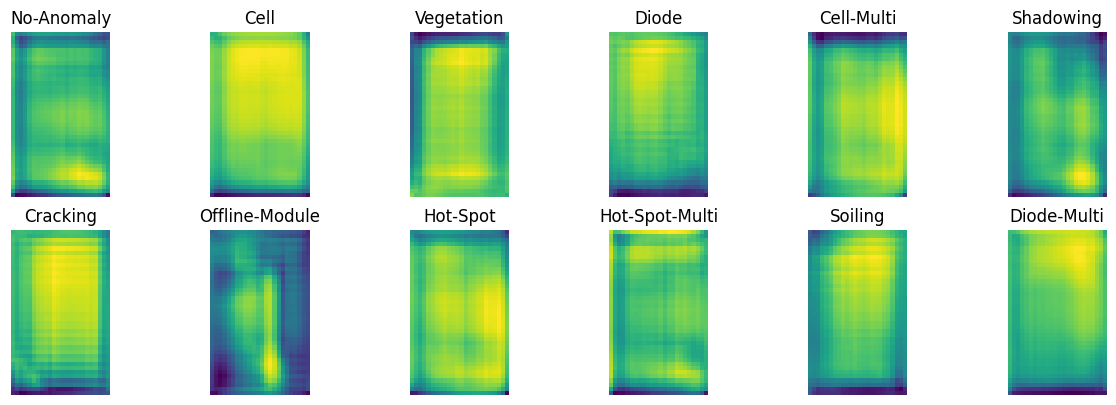

[Epoch 1/20] [D loss: 1.3127152919769287] [G loss: 0.8405480980873108]
[Epoch 2/20] [D loss: 1.4256095886230469] [G loss: 1.3913321495056152]
[Epoch 3/20] [D loss: 1.0074996948242188] [G loss: 1.4928141832351685]
[Epoch 4/20] [D loss: 0.9172316789627075] [G loss: 2.426760673522949]
[Epoch 5/20] [D loss: 0.8413918018341064] [G loss: 1.6061701774597168]
[Epoch 6/20] [D loss: 0.721193790435791] [G loss: 2.9718403816223145]
[Epoch 7/20] [D loss: 0.7888971567153931] [G loss: 2.6851491928100586]
[Epoch 8/20] [D loss: 1.2932225465774536] [G loss: 2.817145586013794]
[Epoch 9/20] [D loss: 0.9771348237991333] [G loss: 2.3930301666259766]
[Epoch 10/20] [D loss: 0.8214210271835327] [G loss: 2.562839984893799]


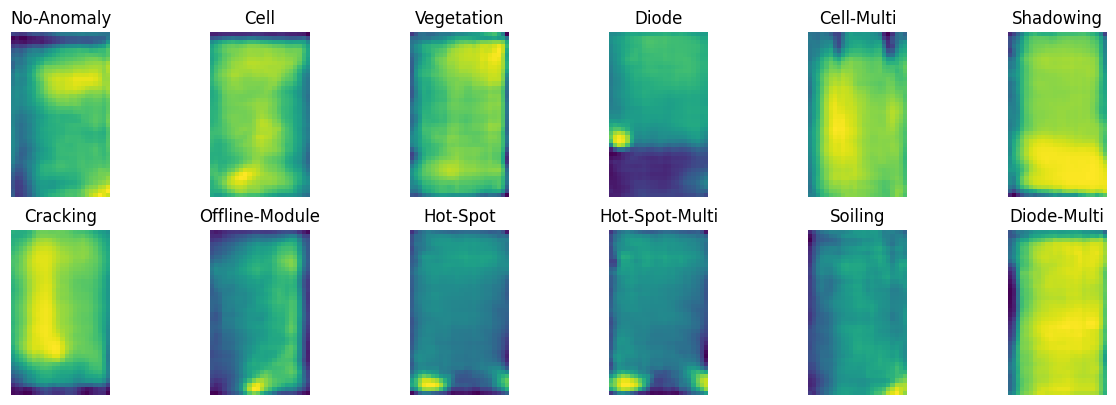

[Epoch 11/20] [D loss: 0.6577657461166382] [G loss: 3.30348539352417]
[Epoch 12/20] [D loss: 0.9701946973800659] [G loss: 2.831904411315918]
[Epoch 13/20] [D loss: 0.8762174844741821] [G loss: 2.4480984210968018]
[Epoch 14/20] [D loss: 0.6847338080406189] [G loss: 2.73390531539917]
[Epoch 15/20] [D loss: 0.8409764170646667] [G loss: 2.6923141479492188]
[Epoch 16/20] [D loss: 0.8312175273895264] [G loss: 1.9296274185180664]
[Epoch 17/20] [D loss: 0.8466763496398926] [G loss: 2.248781442642212]
[Epoch 18/20] [D loss: 0.8732360601425171] [G loss: 2.2614376544952393]
[Epoch 19/20] [D loss: 0.7340235710144043] [G loss: 2.5248069763183594]


In [42]:
X_aug, Y_aug, gan_model = create_XYAugmented(train_df_gan)

In [28]:
classes_list
# 32256

['No-Anomaly',
 'Cell',
 'Vegetation',
 'Diode',
 'Cell-Multi',
 'Shadowing',
 'Cracking',
 'Offline-Module',
 'Hot-Spot',
 'Hot-Spot-Multi',
 'Soiling',
 'Diode-Multi']

In [29]:
torch.save(gan_model.state_dict(), "gan_model.pth")

In [ ]:
# X_aug, Y_aug, gan_model = create_XYAugmented(train_df, gan_model)

In [30]:
def create_XY_fromAug(X, Y):
    x_in = []
    y_in = []
    for x in X:
        x_in.append(np.array(x, dtype=np.float32).reshape((x.shape[-3], x.shape[-2], x.shape[-1])))
    for y in Y:
        y_in.append(np.array(y, dtype=np.float32))
    x_out = np.array(x_in, dtype=np.float32)
    y_out = np.array(y_in, dtype=np.float32)
    return torch.tensor(x_out), torch.tensor(y_out)

X_augf, Y_augf = create_XY_fromAug(X_aug, Y_aug)
print(X_augf.shape), print(Y_augf.shape)

torch.Size([76800, 1, 40, 24])
torch.Size([76800])


(None, None)

In [32]:
model_aug = Classificator(in_dim=X_augf.shape[1:], out_dim=num_classes).to(device)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=0.0003)
model_aug.fit(
    X_augf.to(device),
    Y_augf.to(device),
    optimizer_aug,
    epochs=20, # 150 from paper
    batch_size=64,
    validation_data=(X_val.to(device), y_val.to(device)),
)

[Epoch 0/20] loss: 1.991654634475708, val_acc: 0.5089090340731478
[Epoch 1/20] loss: 1.941540241241455, val_acc: 0.6055017192872773
[Epoch 2/20] loss: 1.788191795349121, val_acc: 0.7120975304782745
[Epoch 3/20] loss: 1.797450304031372, val_acc: 0.747733666770866
[Epoch 4/20] loss: 1.812865138053894, val_acc: 0.8002500781494217
[Epoch 5/20] loss: 1.7118499279022217, val_acc: 0.8071272272585183
[Epoch 6/20] loss: 1.6871811151504517, val_acc: 0.8183807439824945
[Epoch 7/20] loss: 1.681377649307251, val_acc: 0.8443263519849953
[Epoch 8/20] loss: 1.6813769340515137, val_acc: 0.869959362300719
[Epoch 9/20] loss: 1.6814994812011719, val_acc: 0.8687089715536105
[Epoch 10/20] loss: 1.711761236190796, val_acc: 0.8805876836511409
[Epoch 11/20] loss: 1.784212350845337, val_acc: 0.859331040950297
[Epoch 12/20] loss: 1.680437445640564, val_acc: 0.888402625820569
[Epoch 13/20] loss: 1.702992558479309, val_acc: 0.8818380743982495
[Epoch 14/20] loss: 1.6656935214996338, val_acc: 0.8871522350734604
[Epo

In [33]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)

    # Build confusion matrix
    cm = confusion_matrix(labels, pred_labels)
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index=classes, columns=classes)

    # Plot confusion matrix using seaborn
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f', ax=ax)
    plt.show()

In [34]:
def plot_class_metrics(labels, pred_labels, probs, classes):
    from sklearn.metrics import f1_score
    from sklearn.metrics import roc_auc_score

    f1s = []
    aucs = []
    accuracies = []
    for i in range(len(classes)):
        f1 = f1_score(labels, pred_labels, average=None)
        auc = roc_auc_score(labels, probs, average=None, multi_class='ovr')
        accuracy = np.mean(pred_labels[labels == i] == i)
        f1s.append(np.round(f1[i], 2))
        aucs.append(np.round(auc[i], 2))
        accuracies.append(np.round(accuracy, 2))

    df_m = pd.DataFrame({'F1-Score': f1s, 'AUC': aucs, 'Accuracy': accuracies}, index=classes)
    ax = df_m.plot.barh(figsize=(8,8))
    for container in ax.containers:
        ax.bar_label(container)

    plt.show()

Baseline classifier accuracy:  0.78225


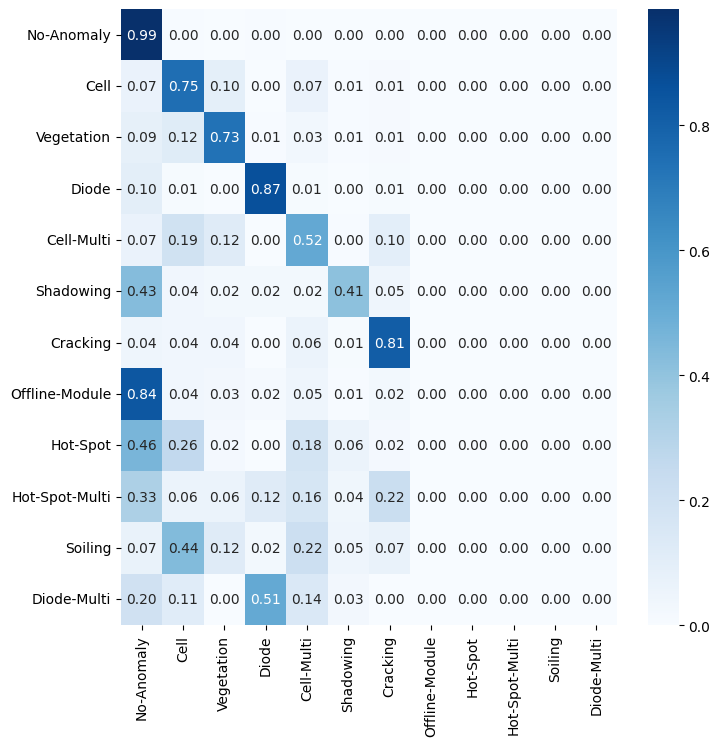

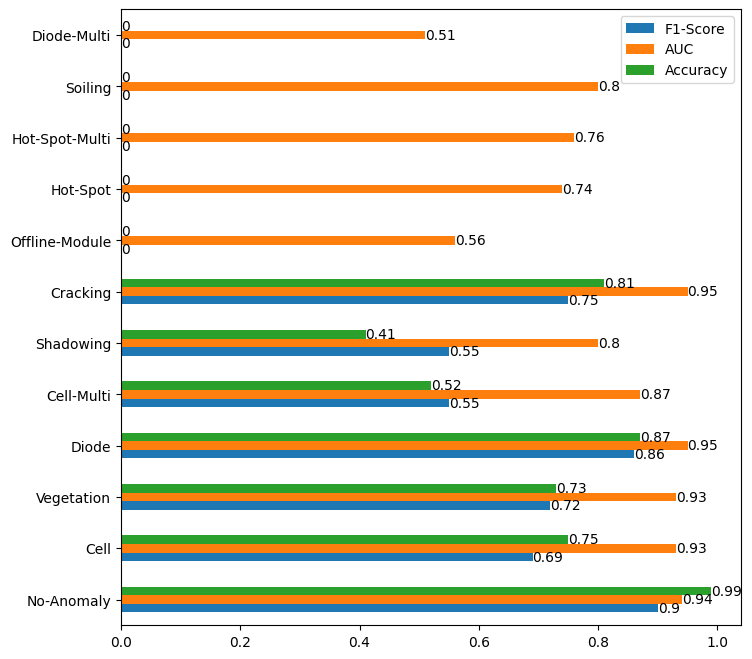

GAugmented data classifier accuracy:  0.87325


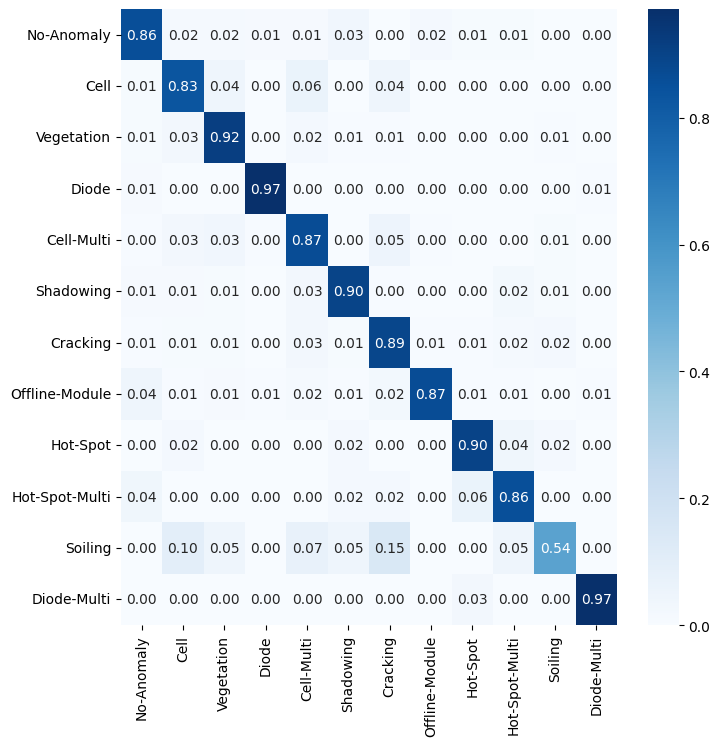

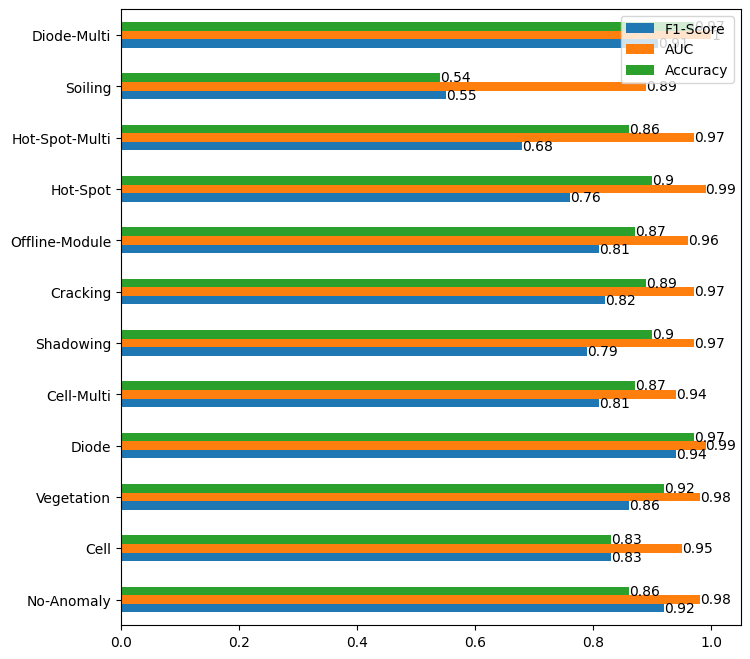

In [36]:
with torch.no_grad():
    y_hat_1 = model.forward(X_test.to(device))
    y_hat_1 = torch.softmax(y_hat_1.cpu(), dim=1)
    _, pred_1 = torch.max(y_hat_1, dim=1)
    val_acc_1 = torch.sum(pred_1 == y_test).item() / y_test.shape[0]
    print("Baseline classifier accuracy: ", val_acc_1)
    plot_confusion_matrix(y_test, pred_1, classes_list)
    plot_class_metrics(y_test, pred_1.numpy(), y_hat_1.numpy(), classes_list)

    y_hat_2 = model_aug.forward(X_test.to(device))
    y_hat_2 = torch.softmax(y_hat_2.cpu(), dim=1)
    _, pred_2 = torch.max(y_hat_2, dim=1)
    val_acc_2 = torch.sum(pred_2 == y_test).item() / y_test.shape[0]
    print("GAugmented data classifier accuracy: ", val_acc_2)
    plot_confusion_matrix(y_test, pred_2, classes_list)
    plot_class_metrics(y_test, pred_2.numpy(), y_hat_2.numpy(), classes_list)

In [ ]:
#plt.figure(figsize=(15,15))
sample = df.groupby('anomaly_class').sample()

plt.figure(figsize=(15,15))
for i, (image_path, class_name) in enumerate(sample.values, start=1):
#for i in range(num_classes):
    c = classes_list.index(class_name)
    image = gan_model.augment(1, c)[0].cpu().numpy()
    plt.subplot(6, 6, i)
    plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
    plt.title(classes_list[c])
    plt.axis('off')
plt.show()

In [ ]:
sample = df.groupby('anomaly_class').sample()

plt.figure(figsize=(15,15))
for i, (image_path, class_name) in enumerate(sample.values, start=1):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plt.subplot(6, 6, i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [ ]:
gan_model_2 = GAugmented((1, 40, 24)).to(device)

In [ ]:
gan_model_2.load_state_dict(torch.load("gan_model.pth"))

In [ ]:
with torch.no_grad():
    plt.figure(figsize=(15,15))
    for i in range(num_classes):
        image = gan_model_2.augment(1, i)#.cpu().numpy()
        image = np.array(image[0].cpu().numpy())
        print(image.shape)
        plt.subplot(6, 6, i+1)
        plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
        plt.title(classes_list[i])
        plt.axis('off')
    plt.show()

In [ ]:
vec = torch.tensor(nn.functional.one_hot(torch.tensor([1]), num_classes=num_classes), dtype=torch.float32)

In [ ]:
fill = torch.zeros([num_classes, num_classes, 40, 24])
for i in range(num_classes):
    fill[i, i, :, :] = 1

fill.shape

In [ ]:
fill[[0, 1]]

# Using GAN

In [43]:
X_gan, Y_gan, _ = create_XYAugmented(train_df, gan_model)
X_gan, Y_gan = create_XY_fromAug(X_gan, Y_gan)
print(X_gan.shape), print(Y_gan.shape)

torch.Size([76800, 1, 40, 24])
torch.Size([76800])


(None, None)

In [44]:
model_gan = Classificator(in_dim=X_gan.shape[1:], out_dim=num_classes).to(device)
optimizer_gan = torch.optim.Adam(model_gan.parameters(), lr=0.0003)
model_gan.fit(
    X_gan.to(device),
    Y_gan.to(device),
    optimizer_gan,
    epochs=20, # 150 from paper
    batch_size=64,
    validation_data=(X_val.to(device), y_val.to(device)),
)

[Epoch 0/20] loss: 1.799213171005249, val_acc: 0.5189121600500156
[Epoch 1/20] loss: 1.74700927734375, val_acc: 0.5842450765864332
[Epoch 2/20] loss: 1.7278988361358643, val_acc: 0.5648640200062519
[Epoch 3/20] loss: 1.7723867893218994, val_acc: 0.6245701781806815
[Epoch 4/20] loss: 1.8127005100250244, val_acc: 0.6305095342294467
[Epoch 5/20] loss: 1.7109167575836182, val_acc: 0.692403876211316
[Epoch 6/20] loss: 1.6858476400375366, val_acc: 0.6858393247889966
[Epoch 7/20] loss: 1.6503020524978638, val_acc: 0.6355110972178806
[Epoch 8/20] loss: 1.6669877767562866, val_acc: 0.6655204751484839
[Epoch 9/20] loss: 1.665644645690918, val_acc: 0.6358236949046577
[Epoch 10/20] loss: 1.6745154857635498, val_acc: 0.6761487964989059
[Epoch 11/20] loss: 1.6867854595184326, val_acc: 0.6967802438261956
[Epoch 12/20] loss: 1.6786882877349854, val_acc: 0.6714598311972492
[Epoch 13/20] loss: 1.759214162826538, val_acc: 0.7077211628633948
[Epoch 14/20] loss: 1.743729591369629, val_acc: 0.70490778368240

Oversampling classifier accuracy:  0.87325


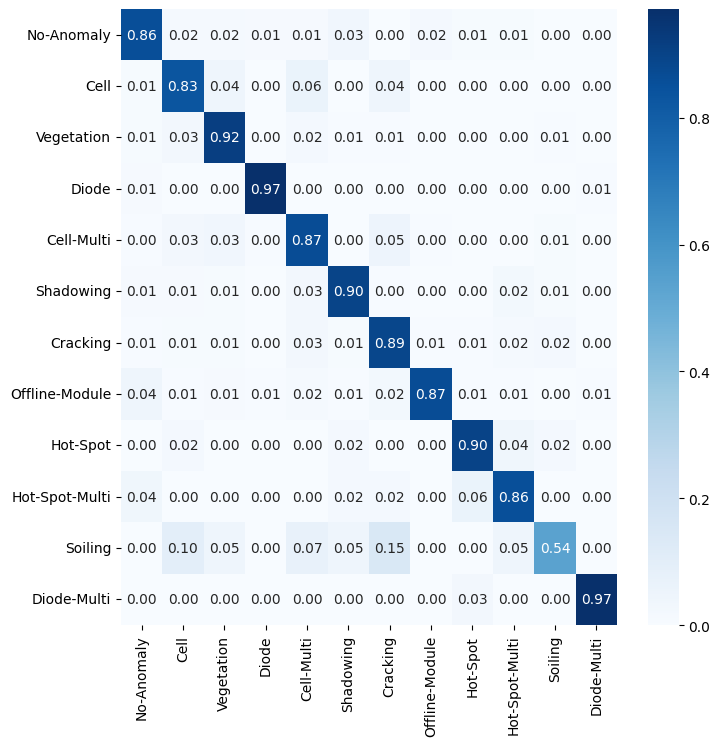

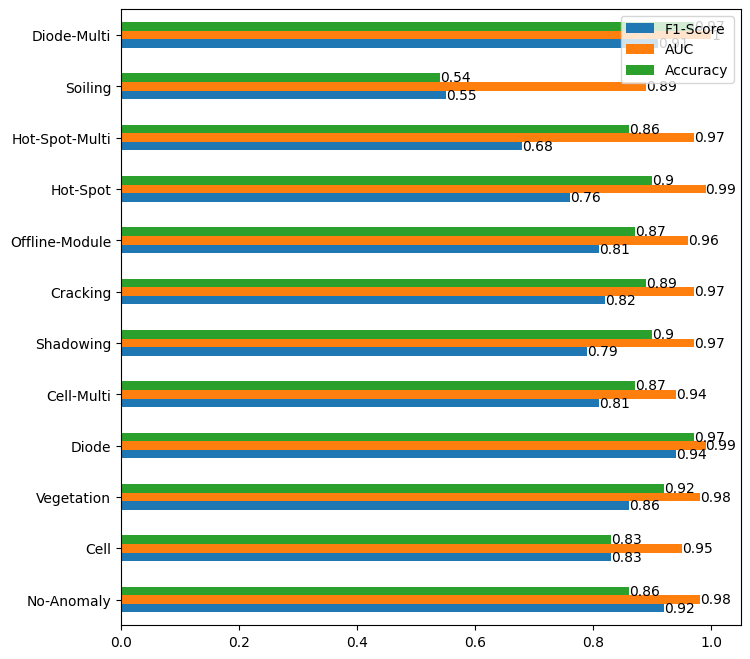

GAugmented data classifier accuracy:  0.73375


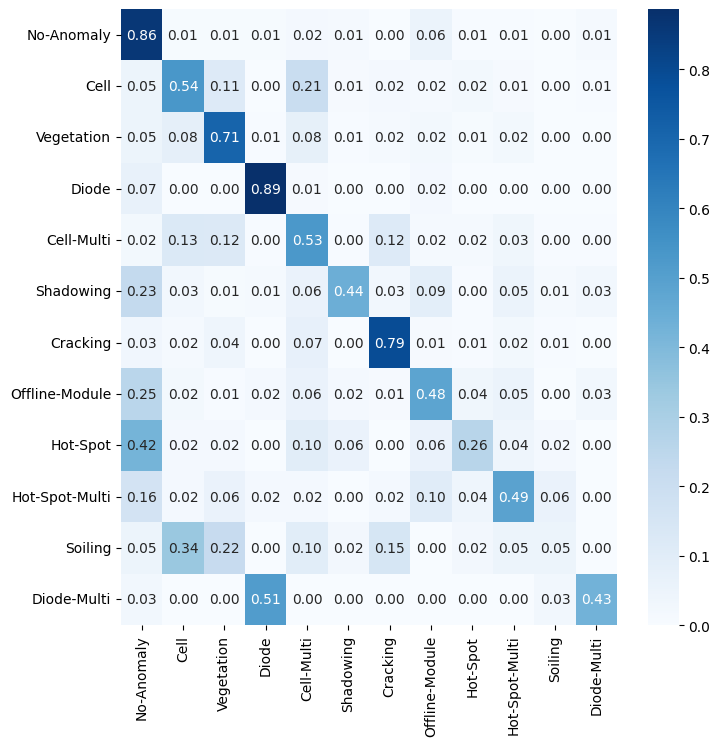

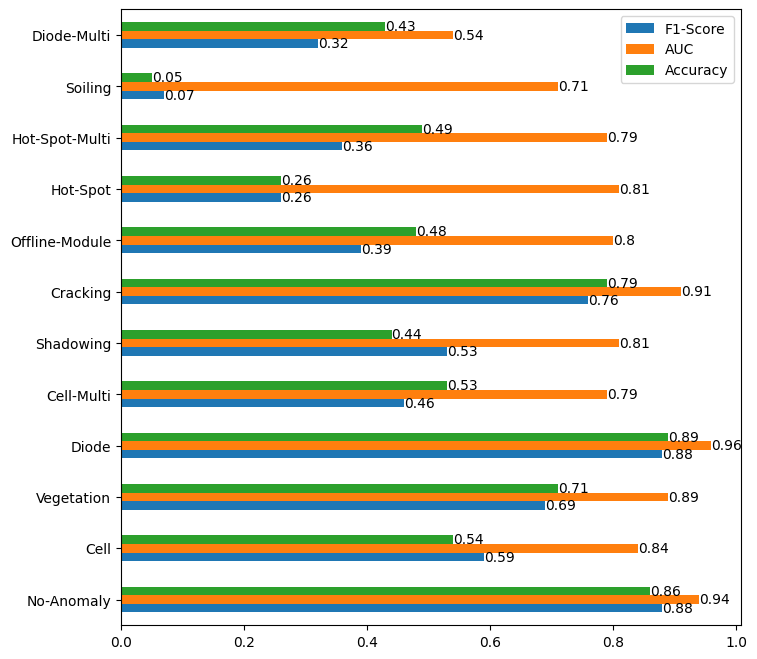

In [45]:
with torch.no_grad():
    y_hat_1 = model_aug.forward(X_test.to(device))
    y_hat_1 = torch.softmax(y_hat_1.cpu(), dim=1)
    _, pred_1 = torch.max(y_hat_1, dim=1)
    val_acc_1 = torch.sum(pred_1 == y_test).item() / y_test.shape[0]
    print("Oversampling classifier accuracy: ", val_acc_1)
    plot_confusion_matrix(y_test, pred_1, classes_list)
    plot_class_metrics(y_test, pred_1.numpy(), y_hat_1.numpy(), classes_list)

    y_hat_2 = model_gan.forward(X_test.to(device))
    y_hat_2 = torch.softmax(y_hat_2.cpu(), dim=1)
    _, pred_2 = torch.max(y_hat_2, dim=1)
    val_acc_2 = torch.sum(pred_2 == y_test).item() / y_test.shape[0]
    print("GAugmented data classifier accuracy: ", val_acc_2)
    plot_confusion_matrix(y_test, pred_2, classes_list)
    plot_class_metrics(y_test, pred_2.numpy(), y_hat_2.numpy(), classes_list)